# Naive Bayes Classifier

In [47]:
import pandas as pd
import numpy as np

Import the already splitted datasets.

In [48]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

## Preprocessing Pipeline

In [49]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 


Drop unused features

In [50]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

In [51]:
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

Preprocessing pipeline definition. This model from Sklearn only support numerical features

In [52]:
numeric_features = train_data.columns
numeric_transformer = StandardScaler()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

## Naive Bayes Classifier Model

In [53]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTEENN,  SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

Given that this model has only the smoothing parameters we decided to perform a normal grid search (not random) over that parameter

NOTE: resempling is added in the preprocessing pipeline in order to be applied olny on training data.

In [54]:
# define the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampling', SMOTETomek(sampling_strategy=0.35, random_state=42)),
    ('clf', GaussianNB())
])

# define the hyperparameter "grid"
param_grid = {
    'clf__var_smoothing': np.logspace(0,-9, num=100)
}

# define the scoring methods
scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, refit='f1', return_train_score=True)
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object'))])),
                                       ('resampling',
                                        SMOTETomek(random_state=42,
                                                   sampling_strategy=0.35)),
                                       ('clf', Gaussian...
                      'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                      'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                      'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                      'specificity': make_scorer(specificity_score, response_method='predict')})

## Model Assessment

### Training scores:

In [55]:
# extract the results of the randomized search and best model idx
cv_results = grid_search.cv_results_
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_

#extract and print matrics
mean_train_scores = {metric: cv_results[f'mean_train_{metric}'][best_index] for metric in scoring.keys()}
std_train_scores = {metric: cv_results[f'std_train_{metric}'][best_index] for metric in scoring.keys()}

print("Training results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_train_scores[metric]:.4f}, Std: {std_train_scores[metric]:.4f}")


Training results of the best model:
Sensitivity - Mean: 0.4385, Std: 0.0016
Specificity - Mean: 0.8332, Std: 0.0011
Accuracy - Mean: 0.7807, Std: 0.0008
Precision - Mean: 0.2870, Std: 0.0007
Recall - Mean: 0.4385, Std: 0.0016
Roc_auc - Mean: 0.7171, Std: 0.0004
F1 - Mean: 0.3469, Std: 0.0004


### Validation scores:

In [56]:
#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.4386, Std: 0.0031
Specificity - Mean: 0.8333, Std: 0.0010
Accuracy - Mean: 0.7808, Std: 0.0006
Precision - Mean: 0.2872, Std: 0.0009
Recall - Mean: 0.4386, Std: 0.0031
Roc_auc - Mean: 0.7170, Std: 0.0023
F1 - Mean: 0.3471, Std: 0.0015


### Test scores:

Accuracy: 0.701
Recall: 0.533
Precision: 0.253
Sensitivity: 0.533
Specificity: 0.73
F1 Score: 0.343
ROC AUC Score: 0.631


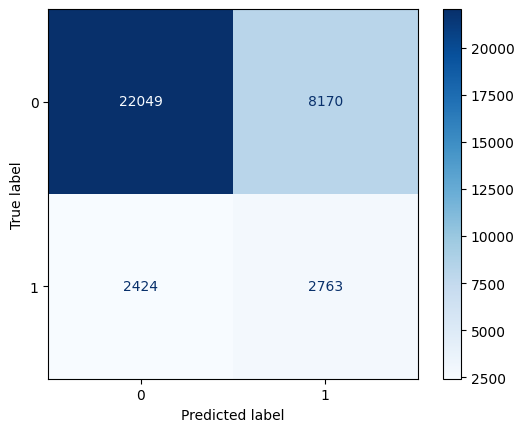

In [57]:
# Predict on the test data
test_predictions = grid_search.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [58]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.73      0.81     30219
           1       0.25      0.53      0.34      5187

    accuracy                           0.70     35406
   macro avg       0.58      0.63      0.57     35406
weighted avg       0.81      0.70      0.74     35406



## Save Results

In [59]:
import sys
sys.path.append('..')
from utils import save_results

resampling = "smotetomek"   # "no", "under", "over", "smotetomek"
save_results('nb', resampling, mean_train_scores, std_train_scores, mean_test_scores, std_test_scores, accuracy, recall, precision, sensitivity_score, specificity_score, f1, roc_auc, report)

## Model Save

In [61]:
import joblib
import os

os.makedirs('best_models', exist_ok=True)
joblib.dump(best_model, 'best_models/nb.pkl')

['best_models/nb.pkl']

## Results: Resampling Techniques and Model Performance



In general, oversampling, undersampling, or techniques combining the two have minimal impact on the overall results achieved by the model. What can be observed is that using a resampling technique or not affects the balance of the model's performance. Without resampling, the model achieves less balanced results across classes, whereas with resampling, the performance becomes more balanced, given that the model find has slightly better ability on recognizing class 1. Since resampling methods do not significantly change the model's outcomes, we opted for **random oversampling** as it provides the best trade-off between performance and execution time. After selecting the oversampler, we manually fine-tuned the resampling parameter with some attempts in order to achieve the best possible model performance with this algorithm.





